# McKinsey Analytics Online Hackathon (Jan 2018)

## Introduction
As part of the McKinsey Analytics Online Hackathon, we are tasked to classify whether a specific loan is approved anot, based on the features of the applicant, and that of the loan.

## Approach
For this hackathon, we begin by exploring the data (and finding relationship between features), before we conduct data cleaning. In this case, data cleaning takes 2 forms: 

1. Imputing missing data using the relationship across different features (where applicable); and 
2. Removing anomalies from the data using arbitrary thresholds.

Following which, we proceed to generate new features, and remove features which are either uninformative of the target label, or cannot be used for the purpose of predicting for the test dataset, either because the competition prohibits the use of such features, or because there were too many missing values.  

For the purpose of prediction, we employ an Extreme Gradient Boosting model with hyperparameter tuning to find the optimal model that will maximise the [roc_auc](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_curve) score, the metric used for evaluating our predictions.

## Result
Our model achieved an AUC score of 0.8480 on the test dataset - good enough to land us the 76th position out of 503 applicants in the public leaderboard.

### Importing libraries and reading dataset

We begin by importing key libraries which will be useful for our analysis, and read the dataset into Python.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import xgboost as xgb

% matplotlib inline

First, we load the training and test dataset. Then, we combine the two datasets into one.

In [9]:
def read_dataframe():
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv') 
    
    nrow_train = train.shape[0]
    combined = pd.concat([train, test])
    
    combined.reset_index(drop=True, inplace=True)
    
    return train, test, combined, nrow_train

train, test, combined, nrow_train = read_dataframe()

### Exploratory Data Analysis

After reading the dataframe. Let's explore the data. First, let's take a look at the first 5 rows of the combined dataframe.

In [10]:
combined.head()

,Approved,City_Category,City_Code,Contacted,Customer_Existing_Primary_Bank_Code,DOB,EMI,Employer_Category1,Employer_Category2,Employer_Code,...,ID,Interest_Rate,Lead_Creation_Date,Loan_Amount,Loan_Period,Monthly_Income,Primary_Bank_Type,Source,Source_Category,Var1
0,0.0,A,C10001,N,B001,23/07/79,NaN,A,4.0,COM0044082,...,APPC90493171225,NaN,15/07/16,NaN,NaN,2000.0,P,S122,G,0
1,0.0,A,C10003,Y,B002,07/12/86,953.0,C,1.0,COM0000002,...,APPD40611263344,13.25,04/07/16,20000.0,2.0,3500.0,P,S122,G,10
2,0.0,C,C10125,Y,B003,10/12/82,NaN,C,4.0,COM0005267,...,APPE70289249423,NaN,19/07/16,45000.0,4.0,2250.0,G,S143,B,0
3,0.0,C,C10477,Y,B003,30/01/89,NaN,A,4.0,COM0004143,...,APPF80273865537,NaN,09/07/16,92000.0,5.0,3500.0,G,S143,B,7
4,0.0,A,C10002,Y,B001,19/04/85,NaN,A,4.0,COM0001781,...,APPG60994436641,NaN,20/07/16,50000.0,2.0,10000.0,P,S134,B,10


Off the bat, we note that there are a total of 22 columns, and there are NA values in the dataset. Also, we note that there are categorical and numerical features in the dataset. To get a better of the data we are dealing with, we can call the `describe` function.

In [11]:
combined.describe(include='all')

,Approved,City_Category,City_Code,Contacted,Customer_Existing_Primary_Bank_Code,DOB,EMI,Employer_Category1,Employer_Category2,Employer_Code,...,ID,Interest_Rate,Lead_Creation_Date,Loan_Amount,Loan_Period,Monthly_Income,Primary_Bank_Type,Source,Source_Category,Var1
count,69713.000000,98622,98622,99750,86322,99732,31928.000000,94127,93757.000000,94127,...,99750,31928.000000,99750,60170.000000,60170.000000,9.975000e+04,86322,99750,99750,99750.000000
unique,NaN,3,704,2,57,11672,NaN,3,NaN,48281,...,99750,NaN,92,NaN,NaN,NaN,2,33,7,NaN
top,NaN,A,C10001,Y,B001,11/01/82,NaN,A,NaN,COM0000002,...,APPY60329882222,NaN,02/09/16,NaN,NaN,NaN,P,S122,B,NaN
freq,NaN,71383,14313,64772,20155,345,NaN,47805,NaN,622,...,1,NaN,2614,NaN,NaN,NaN,56483,44213,42743,NaN
mean,0.014631,NaN,NaN,NaN,NaN,NaN,1099.485718,NaN,3.722623,NaN,...,NaN,19.233814,NaN,39445.986372,3.894399,5.126893e+03,NaN,NaN,NaN,3.952622
std,0.120073,NaN,NaN,NaN,NaN,NaN,745.125218,NaN,0.803623,NaN,...,NaN,5.857761,NaN,30667.188339,1.162487,1.466628e+05,NaN,NaN,NaN,3.819744
min,0.000000,NaN,NaN,NaN,NaN,NaN,118.000000,NaN,1.000000,NaN,...,NaN,11.990000,NaN,5000.000000,1.000000,0.000000e+00,NaN,NaN,NaN,0.000000
25%,0.000000,NaN,NaN,NaN,NaN,NaN,642.750000,NaN,4.000000,NaN,...,NaN,15.250000,NaN,20000.000000,3.000000,1.650000e+03,NaN,NaN,NaN,0.000000
50%,0.000000,NaN,NaN,NaN,NaN,NaN,943.000000,NaN,4.000000,NaN,...,NaN,18.000000,NaN,30000.000000,4.000000,2.500000e+03,NaN,NaN,NaN,2.000000
75%,0.000000,NaN,NaN,NaN,NaN,NaN,1293.000000,NaN,4.000000,NaN,...,NaN,20.000000,NaN,50000.000000,5.000000,4.000000e+03,NaN,NaN,NaN,7.000000


Let's try to find the correlation between different columns. To do so, we can use the `.corr()` function. We will use seaborn's `heatmap` to visulize the correlation across the different features.

In addition, we note that there might be anomalies in the dataset. For example, we note that for EMI, Loan Amount and Monthly Income has a very skewed distribution, judging by their mean-to-standard deviation ratio. We will come to this later, when we search for anomalies in the dataset.

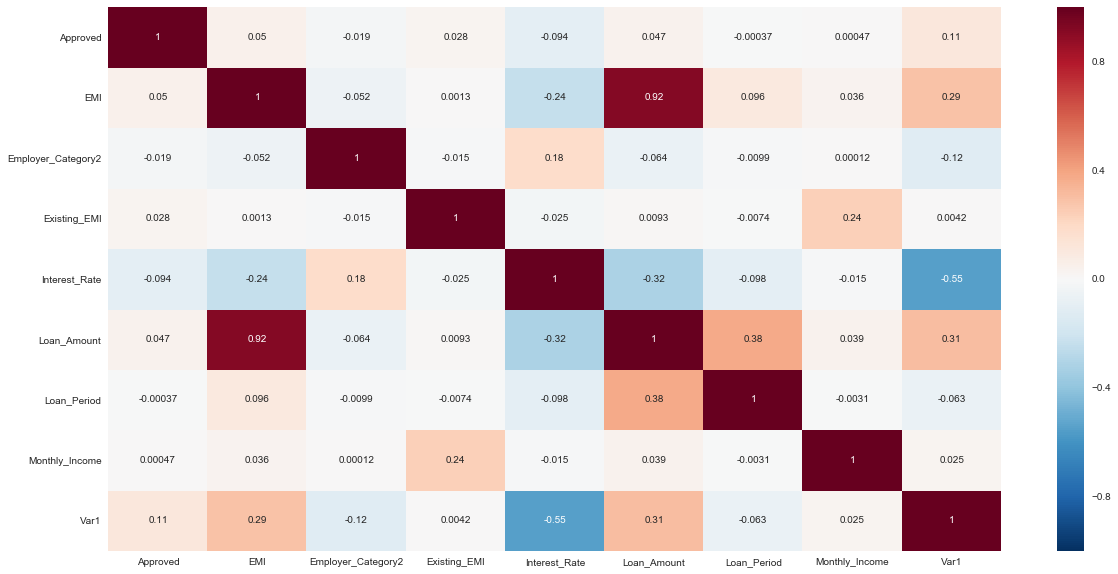

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(combined.corr(), annot=True)

Fromt he heatmap, we note that the features, EMI and Loan Amount are highly correlated with one another (correlation was 0.92). This might lead to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity). Also, based on the correlation with the target label ('Approved'), we find that the informative features are EMI, Interest, Loan Amount and Var1. 

However, we should note that the correlation we are dealing with do not control for the other factors in the dataset.

Lastly, let's find out which columns have missing values.

In [13]:
np.sum(combined.isnull())/combined.shape[0]

Approved                               0.301123
City_Category                          0.011308
City_Code                              0.011308
Contacted                              0.000000
Customer_Existing_Primary_Bank_Code    0.134617
DOB                                    0.000180
EMI                                    0.679920
Employer_Category1                     0.056371
Employer_Category2                     0.060080
Employer_Code                          0.056371
Existing_EMI                           0.000832
Gender                                 0.000000
ID                                     0.000000
Interest_Rate                          0.679920
Lead_Creation_Date                     0.000000
Loan_Amount                            0.396792
Loan_Period                            0.396792
Monthly_Income                         0.000000
Primary_Bank_Type                      0.134617
Source                                 0.000000
Source_Category                        0

Here, we note that only the features Contacted, Gender, ID, Lead_Creation_Date, Monthly_Income, Source, Source_Category and Var1 have no missing values, while the other features have vvarious degrees of missing values. 

As an aside, we also observe that the feature pairs, City_Category and City_Code, Employer_Category1 and Employer_Code, Loan_Amount and Loan_Period, Interest Rate and EMI, and Customer_Existing_Primary_Bank_Code and Primary_Bank_Type have the same amount of missing values. This begs the question: are the features dependent on one another? Intuitively, it appears so. For example, it is not possible to have a city category without a city code. Also, without an Employer Code, it is not possible to have an employer category. 

However, let's find out formally.

In [14]:
# Relationship between City Category and City Code
print np.sum(combined.isnull()).ix['City_Category'] == combined[combined.City_Category.isnull() & combined.City_Code.isnull()].shape[0]

# Relationship between Employer Category1 and Employer Code
print np.sum(combined.isnull()).ix['Employer_Code'] == combined[combined.Employer_Category1.isnull() & combined.Employer_Code.isnull()].shape[0]

# Relationship between Loan Amount and Loan_Period
print np.sum(combined.isnull()).ix['Loan_Amount'] == combined[combined.Loan_Amount.isnull() & combined.Loan_Period.isnull()].shape[0]

# Relationship between Interest Rate and EMI
print np.sum(combined.isnull()).ix['EMI'] == combined[combined.EMI.isnull() & combined.Interest_Rate.isnull()].shape[0]

# Relationship between Customer Existing Primary Bank Code and Primary Bank Type
print np.sum(combined.isnull()).ix['Primary_Bank_Type'] == combined[combined.Customer_Existing_Primary_Bank_Code.isnull() & combined.Primary_Bank_Type.isnull()].shape[0]

True
True
True
True
True


Let's remove feaatures that contains more than 20% missing data. In its place, we will create binary features to indicate whether the applicant had missing data. 

Using the threshold of 20%, we note that the following features will be removed: 'EMI', 'Interest_Rate', 'Loan_Amount', 'Loan_Period'; previously, we note that the missing values across the 4 different columns are common with one another - we will only create 2 columns in this case.

In [15]:
def add_binary_features(combined):
    
    combined['Missing_Loan_EMI'] = combined.EMI.isnull()
    combined['Missing_Loan_Amount'] = combined.Loan_Amount.isnull()
    
    return combined

combined = add_binary_features(combined)

In [16]:
del combined['EMI']
del combined['Interest_Rate']
del combined['Loan_Amount']
del combined['Loan_Period']

### Missing Data Imputation

Before we impute missing data, let's develop a missing data strategy. We note that the data description file provides us with some information pertaining to how we should be imputing missing data - for example, we note that EMI refers to Existing Monthly Installment, while Existing EMI refers to the applicant's EMI of existing loans.

In this case, we can impute missing data for numerical features using the mean of the features, create new categories for missing data for categorical features, and use the most common date to impute for missing data found in date features. Where possible, we will make use of the domain knowledge that we have acquired to impute missing data.

In [17]:
def impute_missing_data(combined):
    # Obtain categorical, numerical and date feature names
    categorical_features = ['City_Category', 'City_Code', 'Contacted', 'Customer_Existing_Primary_Bank_Code',  
                            'Employer_Category1', 'Employer_Category2', 'Employer_Code', 'Gender', 'ID', 
                            'Primary_Bank_Type', 'Source', 'Source_Category', 'Var1']
    
    date_features = ['DOB', 'Lead_Creation_Date']
    
    numerical_features = [feat for feat in combined.columns.tolist() 
                          if feat not in categorical_features and feat not in date_features
                          and not feat.startswith('Missing') and feat != 'Approved']
    
    # Imputing most common values for date and categorical features
    for feat in categorical_features:
        combined[feat].fillna('-1', inplace=True)
    
    for feat in date_features:
        mode = combined[feat].value_counts().index[0]
        combined[feat].fillna(mode, inplace=True)
        
    # Imputing median for numerical features
    for feat in numerical_features:
        mean = combined.describe().ix['mean'].ix[feat]
        combined[feat].fillna(mean, inplace=True)
        
    return combined

combined = impute_missing_data(combined)

Next, we encode our categorical features using sklearn's `LabelEncoder`.

In [18]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(combined):
    categorical_features = ['City_Category', 'City_Code', 'Contacted', 'Customer_Existing_Primary_Bank_Code',  
                            'Employer_Category1', 'Employer_Category2', 'Employer_Code', 'Gender', 'ID', 
                            'Primary_Bank_Type', 'Source', 'Source_Category', 'Var1', 'Missing_Loan_EMI', 
                            'Missing_Loan_Amount']
    for feat in categorical_features:
        enc = LabelEncoder()
        combined[feat] = enc.fit_transform(combined[feat])
    
    return combined

combined = label_encoding(combined)

Let's take a quick look at the correlation across the different features after imputing missing data.

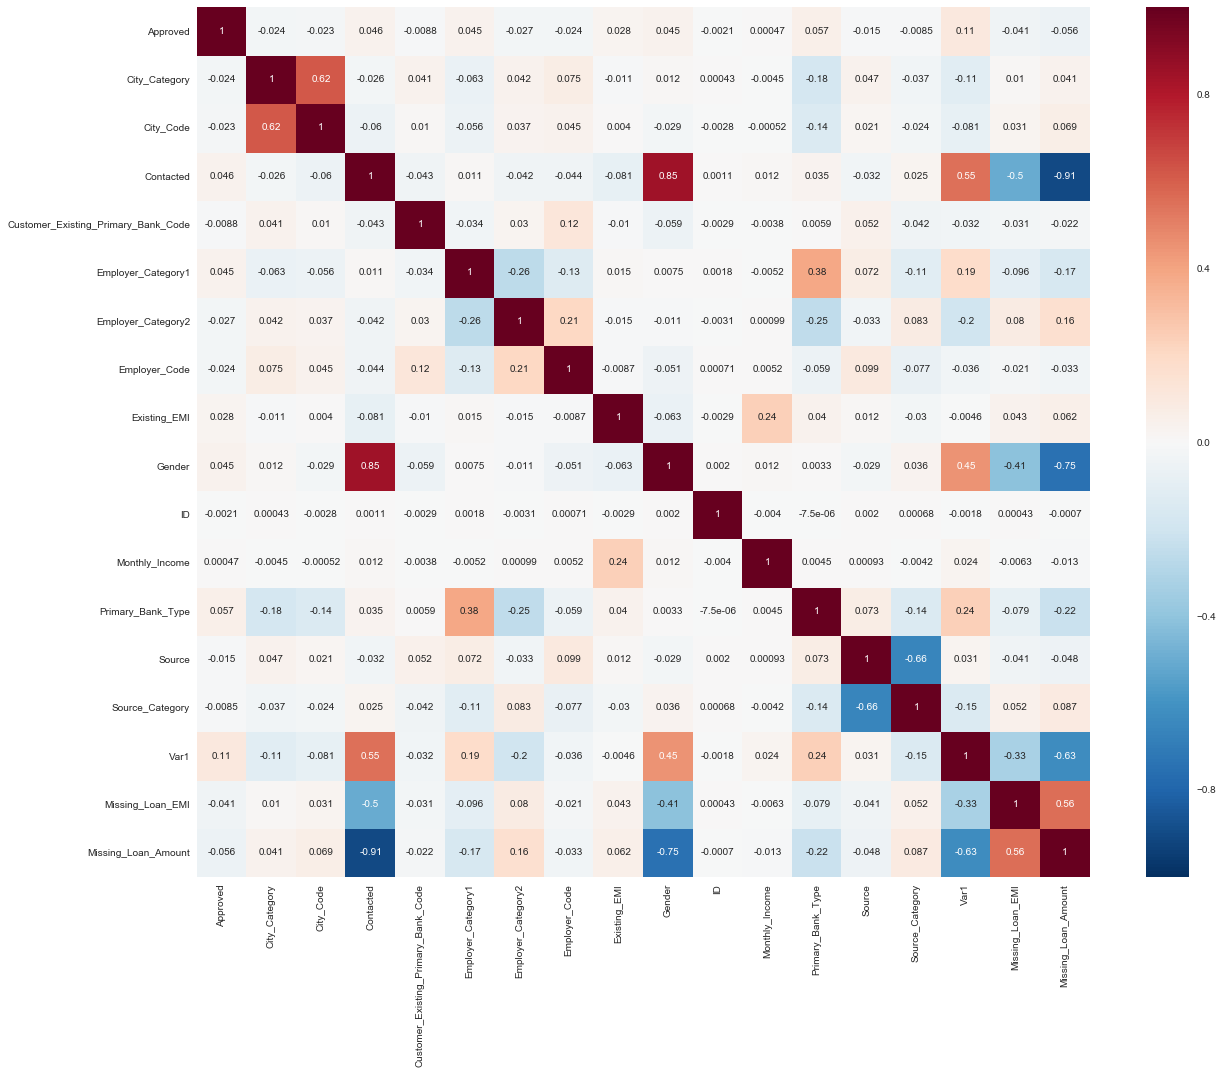

In [19]:
plt.figure(figsize=(20,16))
sns.heatmap(combined.corr(),annot=True)

Let's convert the date features to become age features. To do so, we convert the date features from str to datetime, and then we apply a linear transformation to obtain the age of the features. For example, to get the age of the applicant, we will use the difference between their Date of Birth (the DOB feature) and the date of their application.

In [20]:
def date_to_datetime(combined):
    combined['DOB'] = combined.DOB.apply(lambda date: date[:-2] + '19' + date[-2:])
    combined['DOB'] = pd.to_datetime(combined.DOB, format='%d/%m/%Y')

    combined['Lead_Creation_Date'] = pd.to_datetime(combined.Lead_Creation_Date, format='%d/%m/%y')
    
    return combined

combined = date_to_datetime(combined)

In [21]:
def get_age(combined):
    
    reference_date = pd.to_datetime(max(combined.Lead_Creation_Date))
    combined['Age'] = combined['Lead_Creation_Date'].subtract(combined['DOB']).apply(lambda timedelta: float(timedelta.days)/365)
    combined['Lead_Creation_Years'] = combined['Lead_Creation_Date'].apply(lambda date: float((reference_date - date).days)/365)
    
    del combined['DOB']
    del combined['Lead_Creation_Date']
    return combined

combined = get_age(combined)

### Anomaly Search

Previously, we noted that there were anomalies in the dataset. Let's try to remove these anomalies!

In [22]:
train.describe()

,Employer_Category2,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
count,65415.000000,6.971300e+04,69662.000000,42004.000000,42004.000000,22276.000000,22276.000000,69713.000000,69713.000000
mean,3.720187,5.622283e+03,360.928751,39429.982859,3.890629,19.213570,1101.466242,3.948446,0.014631
std,0.807374,1.747671e+05,2288.517927,30727.595990,1.167491,5.847136,752.661394,3.819214,0.120073
min,1.000000,0.000000e+00,0.000000,5000.000000,1.000000,11.990000,118.000000,0.000000,0.000000
25%,4.000000,1.650000e+03,0.000000,20000.000000,3.000000,15.250000,649.000000,0.000000,0.000000
50%,4.000000,2.500000e+03,0.000000,30000.000000,4.000000,18.000000,941.000000,2.000000,0.000000
75%,4.000000,4.000000e+03,350.000000,50000.000000,5.000000,20.000000,1295.000000,7.000000,0.000000
max,4.000000,3.838384e+07,545436.500000,300000.000000,6.000000,37.000000,13556.000000,10.000000,1.000000


A quick look at the summary of the dataframe seems to suggest that there are anomalies for the following features: Existing_EMI and Monthly_Income. We will impose an arbitrary threshold of 150 times the 75th percentile of each feature, and remove observations that are higher than this threshold.

However, we will not remove observations in the test dataset that exceeds the threshold, as our task is to predict for these observations.

In [23]:
index_to_remove = combined[((combined.Monthly_Income>600000) | (combined.Existing_EMI>52500)) & (combined.Approved.notnull())].index.tolist()
index_to_keep = [index for index in combined.index.tolist() if index not in index_to_remove]

combined = combined.ix[index_to_keep, :]

### Feature Generation and Selection

After imputing missing data, let's select features which are informative of the target label. We will remove the ID feature from our dataset as it has been explicitly mentioned that the feature should not be used for the predictions.

In [24]:
del combined['ID']

First, we create a new feature using monthly income and existing EMI that for the monthly installments paid on existing debt. We will name our feature, Take Home Pay.

In [25]:
combined['Take_Home_Pay'] = combined['Monthly_Income'] - combined['Existing_EMI']

Next, we conduct a logarithmic transformation on the Monthly Income and Existing EMI features.

In [26]:
combined['Monthly_Income'] = np.log1p(combined['Monthly_Income'])
combined['Existing_EMI'] = np.log1p(combined['Existing_EMI'])

In [27]:
combined.columns

Index([u'Approved', u'City_Category', u'City_Code', u'Contacted',
       u'Customer_Existing_Primary_Bank_Code', u'Employer_Category1',
       u'Employer_Category2', u'Employer_Code', u'Existing_EMI', u'Gender',
       u'Monthly_Income', u'Primary_Bank_Type', u'Source', u'Source_Category',
       u'Var1', u'Missing_Loan_EMI', u'Missing_Loan_Amount', u'Age',
       u'Lead_Creation_Years', u'Take_Home_Pay'],
      dtype='object')

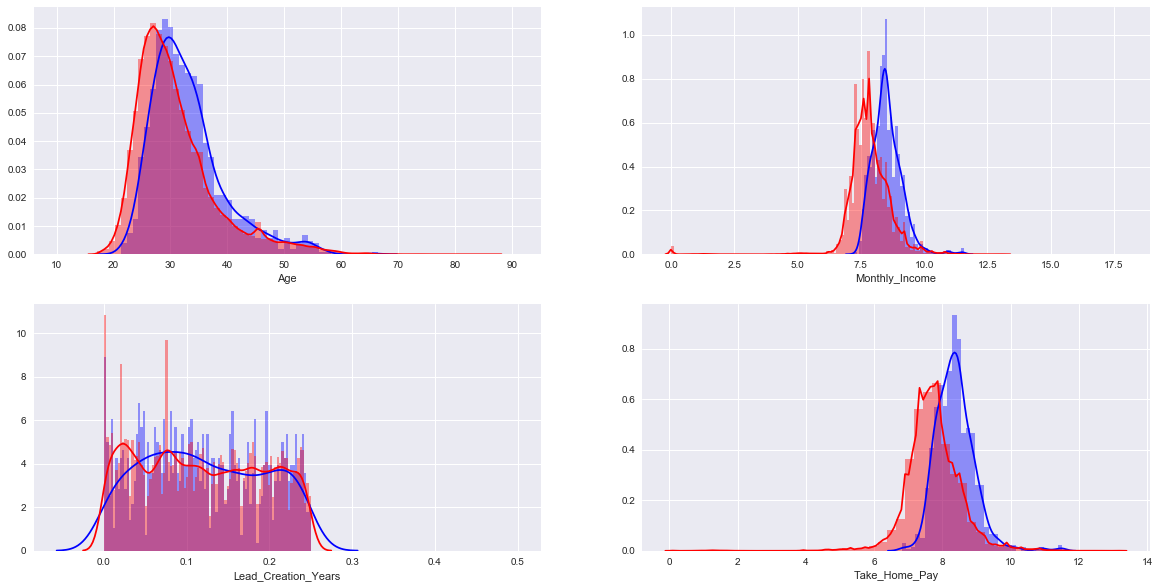

In [28]:
plt.figure(figsize=(20, 10))

plt.subplot(221)
sns.distplot(combined[combined.Approved==1].Age, color='blue',
             bins=np.linspace(10, 91, 80))
sns.distplot(combined[combined.Approved==0].Age, color='red',
             bins=np.linspace(10, 91, 80))

plt.subplot(222)
sns.distplot(combined[combined.Approved==1].Monthly_Income, color='blue',
             bins=np.linspace(0, 18, 180))
sns.distplot(combined[combined.Approved==0].Monthly_Income, color='red',
             bins=np.linspace(0, 18, 180))

plt.subplot(223)
sns.distplot(combined[combined.Approved==1].Lead_Creation_Years, color='blue',
             bins=np.linspace(0, 0.5, 183))
sns.distplot(combined[combined.Approved==0].Lead_Creation_Years, color='red',
             bins=np.linspace(0, 0.5, 183))

plt.subplot(224)
sns.distplot(np.log1p(combined[(combined.Approved==1) & (combined.Take_Home_Pay>0)].Take_Home_Pay), color='blue')
sns.distplot(np.log1p(combined[(combined.Approved==0) & (combined.Take_Home_Pay>0)].Take_Home_Pay), color='red')

In [29]:
def train_test_split(combined):
    target_label = 'Approved'
    features = [feat for feat in combined.columns.tolist() if feat != target_label]
    
    train_idx = combined[combined.Approved.notnull()].index.tolist()
    test_idx = combined[combined.Approved.isnull()].index.tolist()
    
    X_train = combined.ix[train_idx, features].values
    X_test = combined.ix[test_idx, features].values
    y_train = combined[target_label].ix[train_idx].values
    
    return X_train, X_test, y_train

X_train, X_test, y_train = train_test_split(combined)

In [30]:
random_state = 1212

params = {
    'objective': 'binary:logistic',
    'min_child_weight': 10.0,
    'max_depth': 7,
    'colsample_bytree': 0.5,
    'subsample': 0.9,
    'eta': 0.02,
    'max_delta_step': 1.2,
    'eval_metric': 'auc',
    'seed': random_state
}

In [31]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

submission = pd.DataFrame()
submission['ID'] = test['ID'].values
submission['Approved'] = 0

nrounds= 2000
folds = 10
skf = StratifiedKFold(n_splits=folds, random_state=random_state)

for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print 'XGB KFold: %d: ' % int(i+1)
    
    X_subtrain, X_subtest = X_train[train_index], X_train[test_index]
    y_subtrain, y_subtest = y_train[train_index], y_train[test_index]
    
    d_subtrain = xgb.DMatrix(X_subtrain, y_subtrain) 
    d_subtest = xgb.DMatrix(X_subtest, y_subtest) 
    d_test = xgb.DMatrix(X_test)
    
    watchlist = [(d_subtrain, 'subtrain'), (d_subtest, 'subtest')]
    
    mdl = xgb.train(params, d_subtrain, nrounds, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=50)
    
    # Predict test set based on the best_ntree_limit
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    
    # Take the average of the prediction folds to predict for the test set
    submission['Approved'] += p_test/folds

XGB KFold: 1: 
[0]	subtrain-auc:0.5	subtest-auc:0.5
Multiple eval metrics have been passed: 'subtest-auc' will be used for early stopping.

Will train until subtest-auc hasn't improved in 150 rounds.
[50]	subtrain-auc:0.782741	subtest-auc:0.764473
[100]	subtrain-auc:0.878832	subtest-auc:0.827956
[150]	subtrain-auc:0.889231	subtest-auc:0.829451
[200]	subtrain-auc:0.899361	subtest-auc:0.837329
[250]	subtrain-auc:0.905551	subtest-auc:0.84135
[300]	subtrain-auc:0.911153	subtest-auc:0.843658
[350]	subtrain-auc:0.916516	subtest-auc:0.845689
[400]	subtrain-auc:0.920965	subtest-auc:0.845888
[450]	subtrain-auc:0.925344	subtest-auc:0.84608
[500]	subtrain-auc:0.930084	subtest-auc:0.84863
[550]	subtrain-auc:0.934398	subtest-auc:0.848243
[600]	subtrain-auc:0.937995	subtest-auc:0.847302
Stopping. Best iteration:
[499]	subtrain-auc:0.929951	subtest-auc:0.848748

XGB KFold: 2: 
[0]	subtrain-auc:0.5	subtest-auc:0.5
Multiple eval metrics have been passed: 'subtest-auc' will be used for early stopping.



In [32]:
submission.to_csv('data/submission.csv', index=False)